# Calling TYPHOON-OCR-7B on IBM watsonx.ai

In [204]:
import base64
from io import BytesIO
from PIL import Image
from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
import requests
from dotenv import load_dotenv
import os
load_dotenv()

True

In [318]:
# Configuration - Replace with your credentials
API_KEY = os.getenv("WX_AI_API_KEY")
DEPLOYMENT_ID = os.getenv("WX_AI_DEPLOYMENT_ID")  # The ID of your deployed Typhoon OCR model
URL = os.getenv("WX_AI_URL")  # Change based on your region

def get_iam_token(api_key):
    """Get IBM Cloud IAM token"""
    url = os.getenv("CLOUD_IAM_URL")
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {
        "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
        "apikey": api_key
    }
    response = requests.post(url, headers=headers, data=data)
    return response.json()["access_token"]

# Function to encode image to base64
def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Get IAM token
print("Getting IAM token...")
iam_token = get_iam_token(API_KEY)
print("✓ Token received")


# Scoring endpoint URL - Using CHAT API for VLM models
scoring_url = f"{URL}/ml/v1/deployments/{DEPLOYMENT_ID}/text/chat?version=2024-03-19"

# Test OCR on a single image
print("\nTesting Typhoon OCR model...")
print("=" * 60)

# Encode your image
image_path = "/Users/pat/Desktop/custom_FM/images/Screenshot 2568-12-27 at 20.26.24.png"  # Replace with your image path
print(f"Reading image: {image_path}")
image_base64 = encode_image(image_path)
print("✓ Image encoded")

Getting IAM token...
✓ Token received

Testing Typhoon OCR model...
Reading image: /Users/pat/Desktop/custom_FM/images/Screenshot 2568-12-27 at 20.26.24.png
✓ Image encoded


In [ ]:
# You are a precise data extraction assistant. Extract tax invoice information from this Thai tax invoice/receipt document.

# CRITICAL INSTRUCTIONS:
# 1. Extract ONLY printed/typed text that is clearly visible and readable
# 2. IGNORE all handwritten text, signatures, stamps, and annotations
# 3. If a field is not present or unclear, use an empty string ""
# 4. Do NOT guess, infer, or fabricate any values
# 5. Preserve exact formatting for dates, numbers, and Thai text as they appear
# 6. For amounts: extract numbers only (no currency symbols, commas are acceptable)
# 7. For tax IDs: extract exactly 13 digits with no spaces or dashes

# FIELD DEFINITIONS:
# - invoice_number: The document/invoice number (often labeled "เลขที่" or "Invoice No.")
# - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
# - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
# - supplier_address_th: Seller's full address in Thai
# - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
# - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
# - customer_address_th: Buyer's full address in Thai
# - customer_tax_id: Buyer's 13-digit tax identification number
# - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
# - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
# - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
# - line_items: Array of products/services with description, quantity, unit_price, amount

# RESPONSE FORMAT:
# Return ONLY a valid JSON object with NO additional text, markdown formatting, code blocks, or explanations.

# JSON Structure:
# {
#   "invoice_number": "",
#   "invoice_date": "",
#   "supplier_name_th": "",
#   "supplier_address_th": "",
#   "supplier_tax_id": "",
#   "customer_name_th": "",
#   "customer_address_th": "",
#   "customer_tax_id": "",
#   "net_amount": "",
#   "total_tax_amount": "",
#   "total_amount": "",
#   "line_items": [
#     {
#       "description": "",
#       "quantity": "",
#       "unit_price": "",
#       "amount": ""
#     }
#   ]
# }

## Typhoon Prompt

In [320]:
# Prepare the request payload for chat API
payload = {
    "messages": [
        {
            "role": "system",
            "content": """
            You are an OCR extraction engine specialized in Thai and English financial documents.

            Your task is to extract ALL visible printed or typed text from the provided document image as accurately as possible.

            You must NOT summarize, interpret, translate, classify, or reformat the content.
            You must NOT correct spelling or grammar.
            You must NOT guess unreadable characters.

            Your output must strictly reflect what is visually present in the document.
            """
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Extract all the text from this image exactly as it is. You must not miss out any single text"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{image_base64}"
                    }
                }
            ]
        }
    ],
    "parameters": {
        "max_tokens": 1000,
        "temperature": 0.1,
        "top_p": 1.0
    }
}

## OCR Result Real Usage


Calling Typhoon OCR model...
{"natural_text": "บริษัท เพิ่มพูล ประสิทธิ์-ตู้ จำกัด\n637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900\nเลขประจำตัวผู้เสียภาษี/Tax ID 0105534071621 สำนักงานใหญ่ (02)513-7773-4,(02)512-3631\nใบเสร็จรับเงิน/ใบกำกับภาษี(RECEIPT/TAX INVOICE)\nเลขที่/No R36810186\n\nลูกค้า /Customer P00791 บอค. อินโนเวสท์ เอกซ์ตรีมิตส์\nอาคารพร้อมฟันชู 3 ชั้น 16 ห้อง 1608-1614\nซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900\nเลขประจำตัวผู้เสียภาษีอากร / Tax Identification No. 010555117714 สำนักงานใหญ่\n<table>\n<thead>\n<tr>\n<th>ลำดับ Mo.</th>\n<th>รายละเอียด Description</th>\n<th>จำนวน Quantity</th>\n<th>หน่วยละ Unit Price</th>\n<th>ราคารวมภาษี Amount</th>\n</tr>\n</thead>\n<tbody>\n<tr>\n<td>อ้างถึง /Refer to IP6809239</td>\n<td></td>\n<td></td>\n<td></td>\n<td></td>\n</tr>\n<tr>\n<td>คำไฟฟ้า 6211 - 6314</td>\n<td></td>\n<td>103.0 หน่วย</td>\n<td>6.88</td>\n<td>708.64</td>\n</tr>\n<tr>\n<td>2 คำไฟฟ้า 5745 - 5866</td>\n<td></td>\n<td>121.0 หน่วย</td>\n
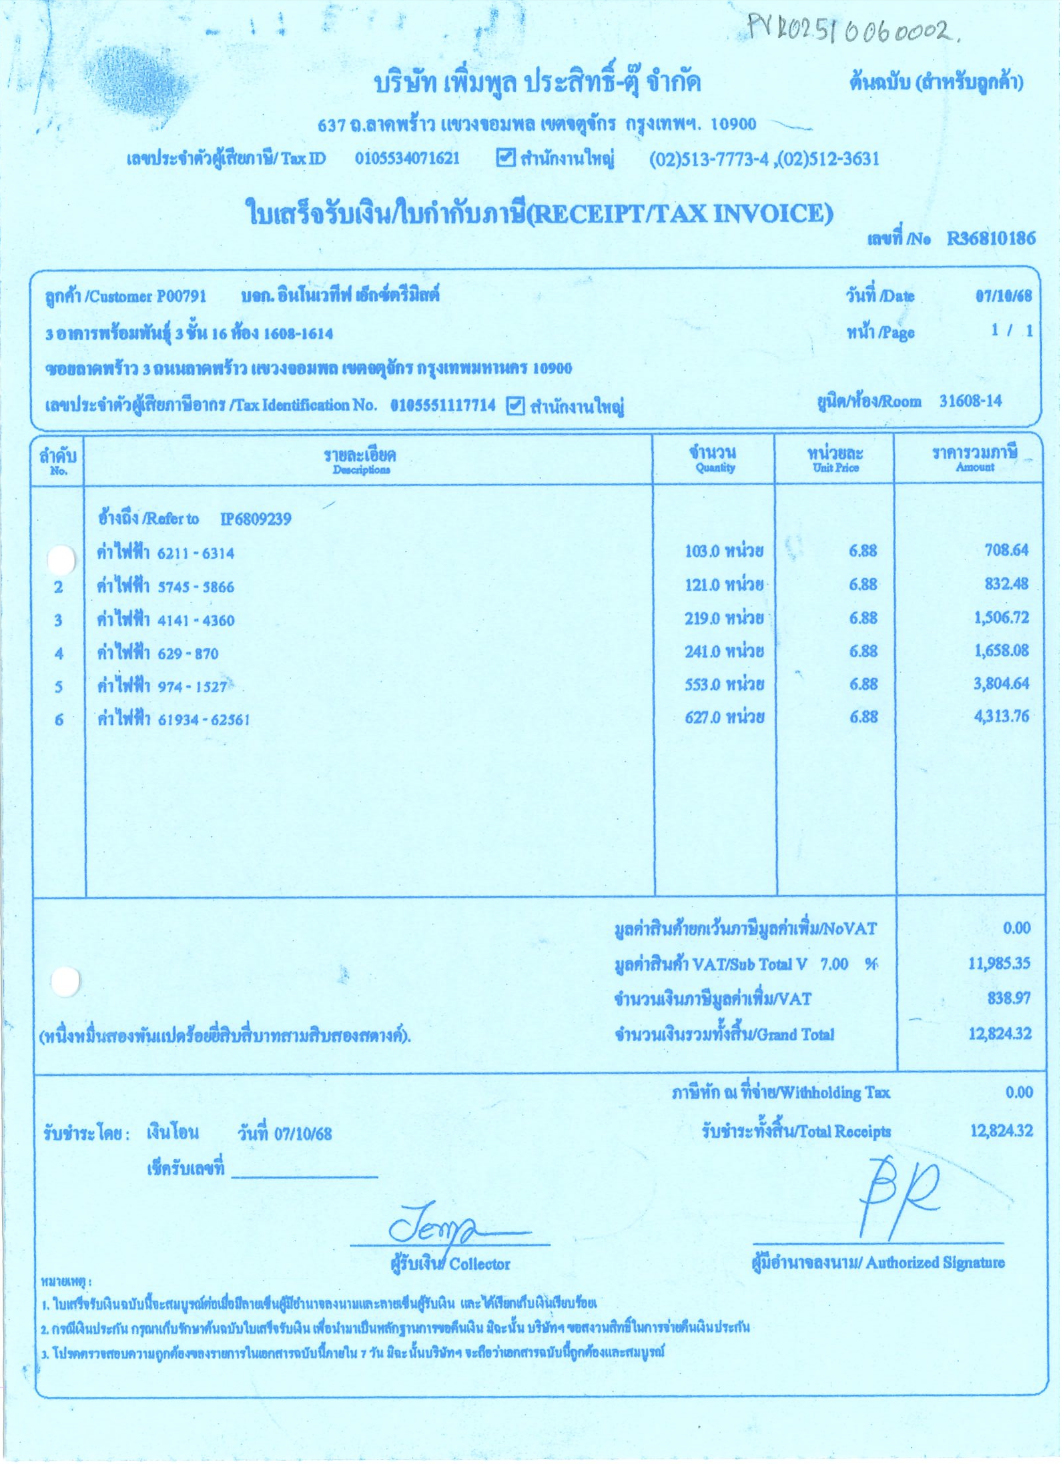

In [321]:
# Make the API request
print("\nCalling Typhoon OCR model...")
headers = {
    "Authorization": f"Bearer {iam_token}",
    "Content-Type": "application/json",
    "Accept": "application/json"
}
response = requests.post(scoring_url, headers=headers, json=payload)
if response.status_code == 200:
    result = response.json()
    extracted_text = result["choices"][0]["message"]["content"]
    print(extracted_text)
    print(payload)
else:   
    print(f"Error: {response.status_code}")
    print(response.text)

# Calling GPT-OSS-120B on IBM watsonx.ai

In [322]:
# import os
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import ModelInference

# --- Configuration ---
API_KEY = os.getenv("WX_AI_API_KEY")
URL = os.getenv("WX_AI_URL")
PROJECT_ID = os.getenv("WX_AI_PROJECT_ID")

MODEL_ID = "openai/gpt-oss-120b"

credentials = Credentials(
    url=URL,
    api_key=API_KEY
)

client = APIClient(credentials)
client.set.default_project(PROJECT_ID)

print("✓ Client initialized and project set.")

✓ Client initialized and project set.


In [323]:
parameters = {
    "decoding_method": "greedy",
    "max_new_tokens": 1500,
    "repetition_penalty": 1.1,
    "reasoning_effort": "low" # Options: "low", "medium", "high"
}

model = ModelInference(
    model_id=MODEL_ID,
    params=parameters,
    credentials=credentials,
    project_id=PROJECT_ID
)

print(f"✓ Model {MODEL_ID} initialized with reasoning_effort='low'.")

✓ Model openai/gpt-oss-120b initialized with reasoning_effort='low'.


## GPT OSS Prompt

In [324]:
raw_text = extracted_text

prompt = f"""Extract information from the following text into valid JSON format.

  TEXT TO PROCESS:
  {raw_text}

  FIELD DEFINITIONS:
  - invoice_number: The document/invoice number (often labeled "Tax inv. No.","เลขที่/No.", "Invoice No", "NO." or "เลขที่") or sometimes it starts with "IN" then follow with number; do not extract the word "NO")
  - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
  - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย", "Seller" or sometimes not labeled just only the company name). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...). The clue for identifying this is for example "Co. Limited","บริษัท","จำกัด" "
  - supplier_address_th: Seller's full address in Thai (section labeled "ที่อยู่" or "Address")
  - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
  - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" "ลูกค้า" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...). Exclude code, include only customer name. The customer name should be a company name."
  - customer_address_th: Buyer's full address in Thai (should not include the name of the buyer as it supposed to be included in the "customer_name_th" field)
  - customer_tax_id: Buyer's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
  - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
  - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
  - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
  - line_items: Array of products/services with description, quantity, unit_price, amount. Exclude "อ้างถึง/Refer to" or "ค้างจึง/Refer to" as it doesnt count as an item


  JSON Structure:
  {{
    "invoice_number": "",
    "invoice_date": "",
    "supplier_name_th": "",
    "supplier_address_th": "",
    "supplier_tax_id": "",
    "customer_name_th": "",
    "customer_address_th": "",
    "customer_tax_id": "",
    "net_amount": "",
    "total_tax_amount": "",
    "total_amount": "",
    "line_items": [
      {{
        "description": "",
        "quantity": "",
        "unit_price": "",
        "amount": ""
      }}
    ]
  }}

  CRITICAL: Return ONLY a valid JSON object. No explanation, no markdown blocks, no thinking process."""

messages = [
    {
        "role": "system",
        "content": "You are a precise information extraction assistant. You output raw JSON only."
    },
    {
        "role": "user",
        "content": prompt
    }
]

print(f"Calling model with Chat API (low reasoning effort)...\n")
response = model.chat(messages=messages)

print("--- Model Response ---")
if 'choices' in response:
    content = response['choices'][0]['message']['content']
    print(content)
else:
    print(response)

Calling model with Chat API (low reasoning effort)...



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ibm_watsonx_ai/foundation_models/inference/base_model_inference.py:1177: UserWarning: Parameters [decoding_method, max_new_tokens, repetition_penalty] is/are not recognized and will be ignored.
  warn(invalid_params_warning)


--- Model Response ---
{
  "invoice_number": "R36810186",
  "invoice_date": "",
  "supplier_name_th": "บริษัท เพิ่มพูล ประสิทธิ์-ตู้ จำกัด",
  "supplier_address_th": "637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900",
  "supplier_tax_id": "0105534071621",
  "customer_name_th": "บอค. อินโนเวสท์ เอกซ์ตรีมิตส์",
  "customer_address_th": "อาคารพร้อมฟันชู 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900",
  "customer_tax_id": "010555117714",
  "net_amount": "11,985.35",
  "total_tax_amount": "",
  "total_amount": "",
  "line_items": [
    {
      "description": "คำไฟฟ้า 6211 - 6314",
      "quantity": "103.0",
      "unit_price": "6.88",
      "amount": "708.64"
    },
    {
      "description": "2 คำไฟฟ้า 5745 - 5866",
      "quantity": "121.0",
      "unit_price": "6.88",
      "amount": "832.48"
    },
    {
      "description": "3 คำไฟฟ้า 4141 - 4360",
      "quantity": "219.0",
      "unit_price": "6.88",
      "amount": "1,506.72"
    },
 

In [325]:
import json

data = json.loads(content)

print(data)
print(type(data)) 


{'invoice_number': 'R36810186', 'invoice_date': '', 'supplier_name_th': 'บริษัท เพิ่มพูล ประสิทธิ์-ตู้ จำกัด', 'supplier_address_th': '637 ถ.ลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพฯ. 10900', 'supplier_tax_id': '0105534071621', 'customer_name_th': 'บอค. อินโนเวสท์ เอกซ์ตรีมิตส์', 'customer_address_th': 'อาคารพร้อมฟันชู 3 ชั้น 16 ห้อง 1608-1614 ซอยลาดพร้าว 3 ถนนลาดพร้าว แขวงจอมพล เขตจตุจักร กรุงเทพมหานคร 10900', 'customer_tax_id': '010555117714', 'net_amount': '11,985.35', 'total_tax_amount': '', 'total_amount': '', 'line_items': [{'description': 'คำไฟฟ้า 6211 - 6314', 'quantity': '103.0', 'unit_price': '6.88', 'amount': '708.64'}, {'description': '2 คำไฟฟ้า 5745 - 5866', 'quantity': '121.0', 'unit_price': '6.88', 'amount': '832.48'}, {'description': '3 คำไฟฟ้า 4141 - 4360', 'quantity': '219.0', 'unit_price': '6.88', 'amount': '1,506.72'}, {'description': '4 คำไฟฟ้า 629 - 870', 'quantity': '241.0', 'unit_price': '6.88', 'amount': '1,658.08'}, {'description': '5 คำไฟฟ้า 974 - 1527', 'quanti

In [ ]:
import json

# Write JSON file
with open("/Users/pat/Desktop/custom_FM/working/comparison/result/output_PPP-001.json", "w", encoding="utf-8") as f:
    json.dump(
        data,
        f,
        ensure_ascii=False,  # keep Thai characters readable
        indent=2             # pretty print
    )

print("JSON file created")

JSON file created
